## Applying a simple Logisitic Regression Model

In [1]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_json('../../Dataset/Random Acts Of Pizza/trainingData.json')
df_train.shape

(4040, 27)

In [3]:
df_sentiment = pd.read_csv('../../../Downloads/sentiment.csv',index_col=0)
print df_sentiment.shape

(5718, 7)


In [4]:
df_sentiment.drop(['index','request_text','positive','negative','neutral'],axis=1,inplace=True)
df_sentiment.head()

,request_id,sentiment
0,t3_rcb83,Negative
1,t3_lpu5j,Negative
2,t3_mxvj3,Negative
3,t3_1i6486,Neutral
4,t3_14gmeb,Negative


In [5]:
df_train = df_train.merge(df_sentiment,on='request_id')
print df_train.shape

(4040, 28)


In [6]:
sent = []
for sentiment in df_sentiment['sentiment']:
    try:
        if 'pos' in sentiment.lower():
            sent.append(1)
        elif 'neg' in sentiment.lower():
            sent.append(0)
        else:
            sent.append(0)
    except:
        sent.append(0)

In [7]:
df_train['sentiment'] = sent[:4040]

In [8]:
df_train.head(2)

,data_type,evidentiality,giver_username_if_known,impolite,narrative,polite,received,reciprocity,request_id,request_length,...,requester_number_of_subreddits_at_request,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,similarity,topics,unix_timestamp_of_request,unix_timestamp_of_request_utc,sentiment
0,train,0,N/A,0.448794,0.375000,0.551206,False,0,t3_rcb83,16,...,12,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,116,fohacidal,"[1971, 0.9757849288]",14,1332652424,1332648824,0
1,train,0,N/A,0.426589,0.067797,0.573411,True,0,t3_16upcl,59,...,18,"[4chan, AskReddit, IAmA, ImGoingToHellForThis,...",1738,2634,seabass86,"[3782, 0.9925300426]",1,1358559286,1358559286,0


In [9]:
train = df_train.copy()
train.drop([col for col in train.columns if train[col].dtype == object],axis=1,inplace=True)
train.drop(['topics','requester_days_since_first_post_on_raop_at_request','requester_number_of_comments_at_request',\
           'requester_number_of_comments_in_raop_at_request','requester_number_of_posts_at_request',\
           'requester_number_of_posts_on_raop_at_request','requester_number_of_subreddits_at_request',\
           'unix_timestamp_of_request','unix_timestamp_of_request_utc'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 11 columns):
evidentiality                                   4040 non-null int64
impolite                                        4040 non-null float64
narrative                                       4040 non-null float64
polite                                          4040 non-null float64
received                                        4040 non-null bool
reciprocity                                     4040 non-null int64
request_length                                  4040 non-null int64
requester_account_age_in_days_at_request        4040 non-null float64
requester_upvotes_minus_downvotes_at_request    4040 non-null int64
requester_upvotes_plus_downvotes_at_request     4040 non-null int64
sentiment                                       4040 non-null int64
dtypes: bool(1), float64(4), int64(6)
memory usage: 351.1 KB


In [10]:
train.dropna(inplace=True)
print train.shape

(4040, 11)


In [11]:
y = train.pop('received')
print y.shape

(4040,)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import roc_auc_score

In [13]:
def scorer(estimator,X,y):
    return roc_auc_score(y,estimator.predict(X))

In [14]:
def apply_model(model,df,y,cv=5):
    score = cross_val_score(model,train.values,y,scoring=scorer,cv=5)
    return score

In [15]:
linear = LogisticRegression()
score = cross_val_score(linear,train.values,y,scoring=scorer,cv=5)

In [16]:
print score.mean()

0.500226959466


### Creating the credibility of some new features
* Politeness
* Impoliteness

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

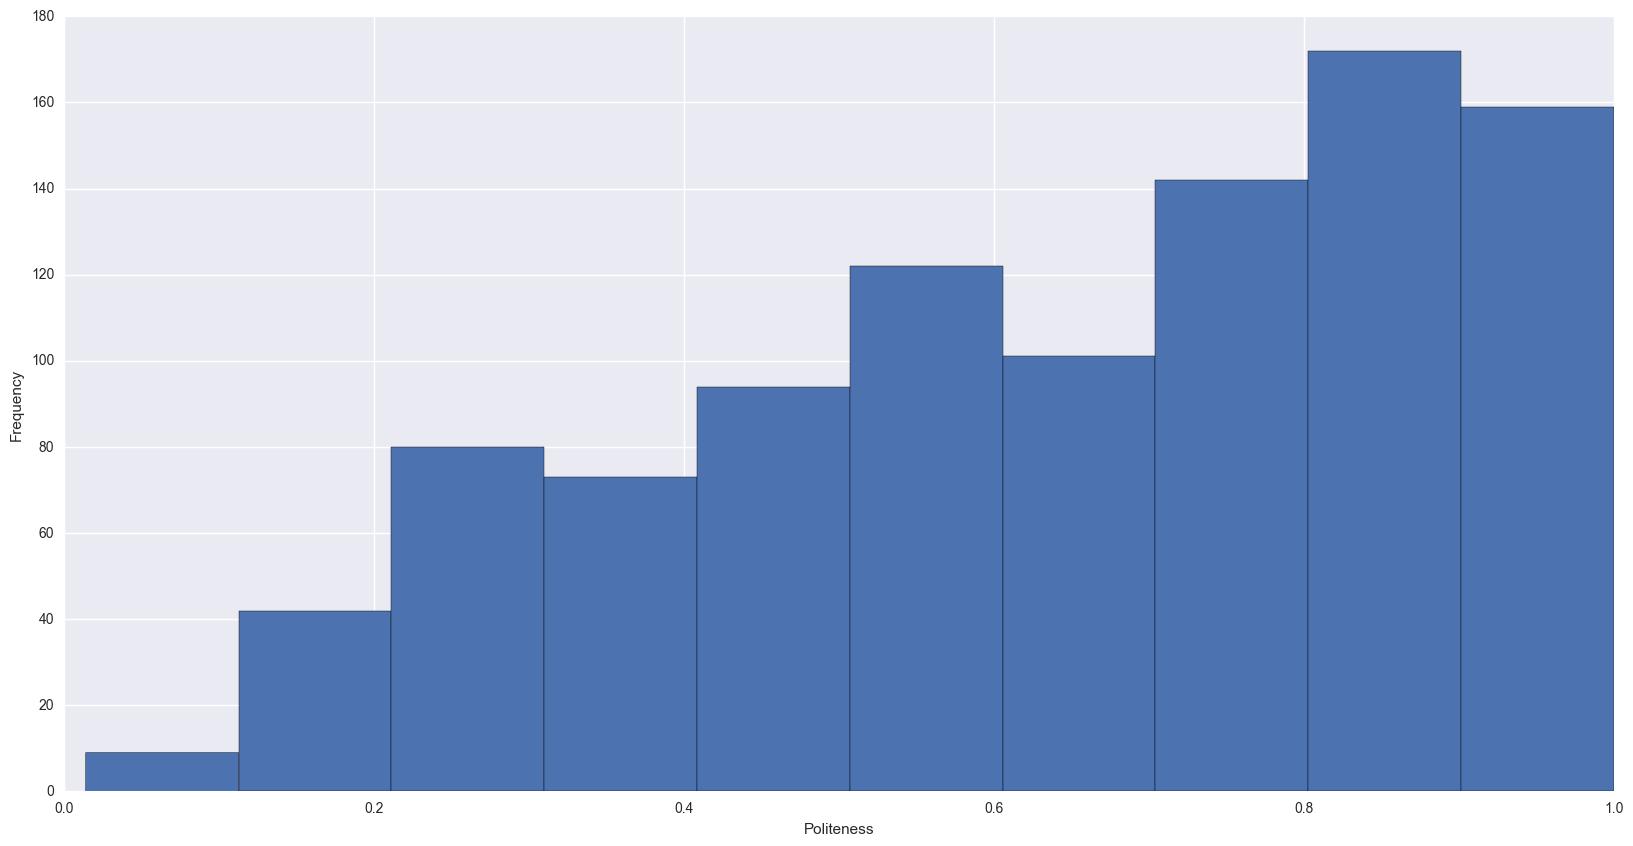

In [18]:
df_train[df_train['received'] == True]['polite'].hist()
plt.xlabel('Politeness')
plt.ylabel('Frequency')
plt.show()

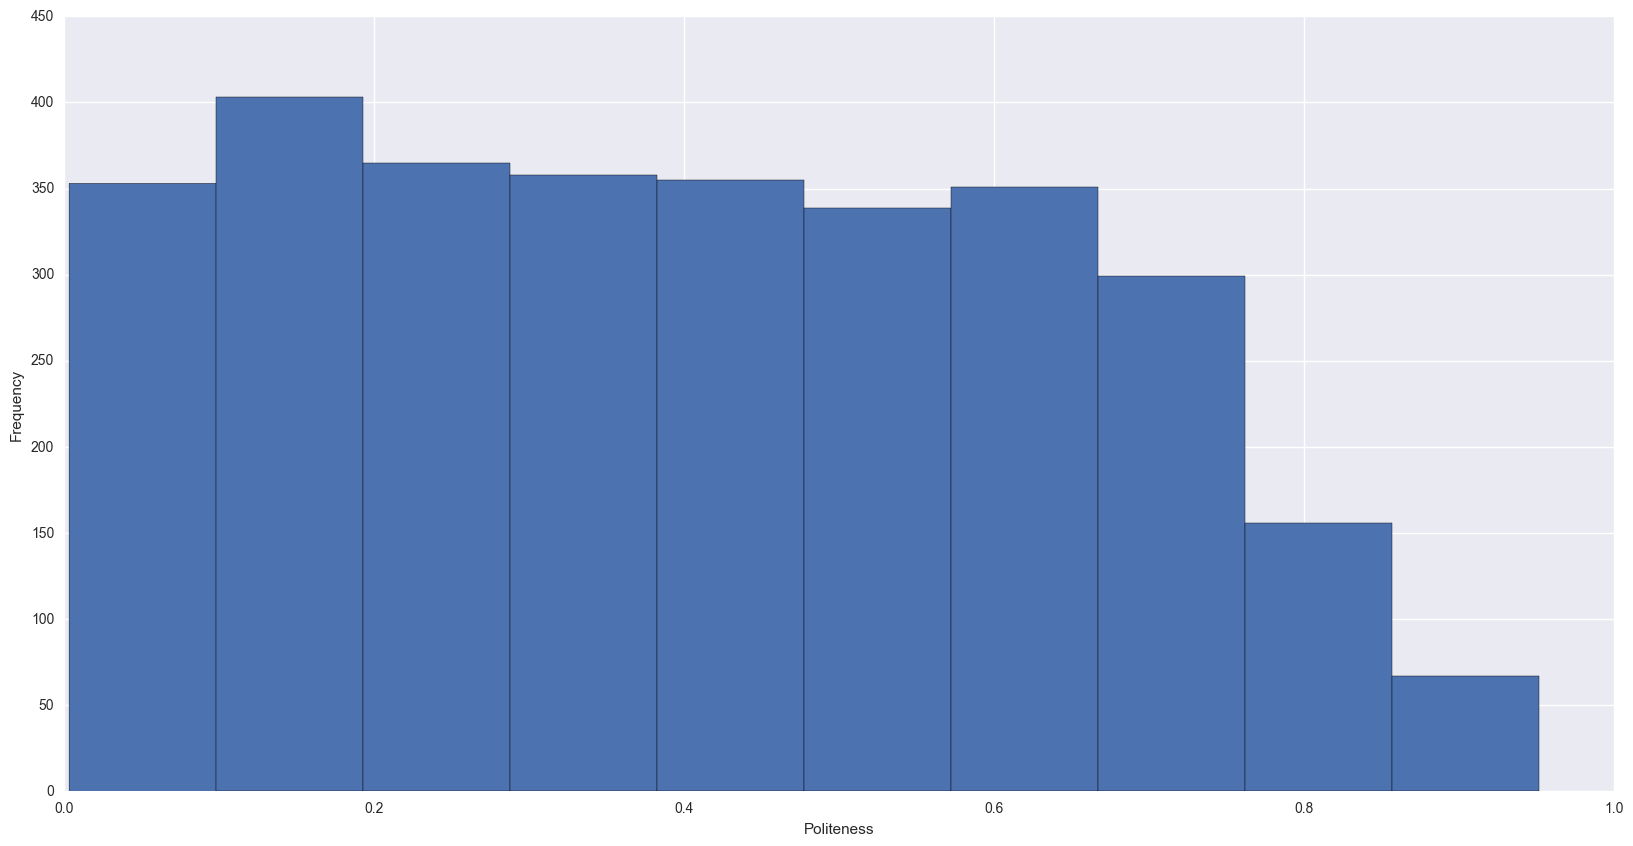

In [19]:
df_train[df_train['received'] == False]['impolite'].hist()
plt.xlabel('Politeness')
plt.ylabel('Frequency')
plt.show()

### Topic modelling as an added feature

### Using giver_username as a feature

In [20]:
train['giver'] = df_train['giver_username_if_known'].map({'N/A':0})
train['giver'].fillna(1,inplace=True)

In [21]:
linear = LogisticRegression()
score = apply_model(linear,train,y,cv=5)
print score.mean()

0.56116294006


### Narrative as a binary coded feature

In [22]:
import operator

In [23]:
narrative = {'Money': 'money now broke week until time last \
day when today tonight paid next first night after tomorrow \
month while account before long Friday rent buy bank still \
bills bills ago cash due due soon past never paycheck check \
spent years poor till yesterday morning dollars financial \
hour bill evening credit budget loan bucks deposit dollar \
current payed'.split(),'Job':'work job paycheck unemployment\
interview fired employment hired hire'.split(),'Student':'college\
student school roommate studying university finals semester class\
study project dorm tuition'.split(),'Family':'family mom wife parents\
mother hus- band dad son daughter father parent mum'.split(),'Craving':'friend \
girlfriend craving birthday boyfriend celebrate party game games movie\
date drunk beer celebrating invited drinks crave wasted invite'.split()}

In [24]:
request_narrative = []
narration = []
for request in df_train['request_text_edit_aware']:
    word_count = {'Money':0,'Job':0,'Student':0,'Family':0,'Craving':0}
    n = 0
    for word in request.split():
        for lexicon in narrative:
            if word in narrative[lexicon]:
                word_count[lexicon] += 1
    narration.append(max(word_count.iteritems(), key=operator.itemgetter(1))[0])

In [25]:
train['narrative_topic'] = narration

In [26]:
train = pd.get_dummies(train,columns=['narrative_topic'])

In [27]:
linear = LogisticRegression()
score = apply_model(linear,train,y,cv=5)
print score.mean()

0.584267808666


### Modelling the features as given by the paper

#### Community Age as a Decile Feature

In [28]:
df_train['community_age'] = pd.cut(df_train.requester_account_age_in_days_at_request,10)

In [29]:
df_train = pd.get_dummies(df_train,columns=['community_age'])

#### Polinteness (Gratitude) as a Binary Feature

In [30]:
df_train.polite = df_train.polite > np.mean(df_train.polite)

In [31]:
df_train.drop(['impolite'],axis=1,inplace=True)

#### Request Length as a group of hundreds

In [32]:
df_train['request_length_hundred'] = (df_train.request_length/100).astype(int)

#### Karma points as a Decile Feature

In [33]:
df_train['karma'] = pd.cut(df_train.requester_upvotes_minus_downvotes_at_request,10)
df_train = pd.get_dummies(df_train,columns=['karma'])

#### Whether the requester has posted before as a Binary Feature

In [34]:
df_train['posted_on_raop_before'] = df_train.requester_number_of_posts_on_raop_at_request > 0

#### Narrative of the request as a Binary Feature

In [35]:
df_train = pd.concat([df_train,train[[col for col in train.columns if col.startswith('narrative')]]],axis=1)

#### First Half Of the Month as Binary Feature

In [36]:
import datetime

In [37]:
df_train['First_Half_Of_Month'] = [datetime.datetime.fromtimestamp(int(timestamp)).day for timestamp in \
                                  df_train.unix_timestamp_of_request]
df_train['First_Half_Of_Month'] = df_train['First_Half_Of_Month'] < 15

In [38]:
train = df_train.copy()

In [39]:
columns = ['data_type','giver_username_if_known','narrative','request_id','request_length',\
           'request_text_edit_aware','request_title','requester_account_age_in_days_at_request',\
           'requester_days_since_first_post_on_raop_at_request','requester_number_of_comments_at_request',\
           'requester_number_of_comments_in_raop_at_request','requester_number_of_posts_at_request',\
           'requester_number_of_posts_on_raop_at_request','requester_number_of_subreddits_at_request',\
           'requester_subreddits_at_request','requester_upvotes_minus_downvotes_at_request',\
           'requester_upvotes_plus_downvotes_at_request','requester_username','similarity','topics',\
           'unix_timestamp_of_request','unix_timestamp_of_request_utc','positive','negative','neutral',\
           'sentiment_Negative','sentiment_Neutral','sentiment_Positive','sentiment_Verynegative',\
           'sentiment_Verypositive','sentiment_no_sentiment','topic_0','topic_1','topic_2','topic_3',\
           'topic_4','topic_5','topic_6','topic_7','topic_8','topic_9','topic_10','topic_11','topic_12',\
           'topic_13','topic_14','topic_15','topic_16','topic_17','topic_18','topic_19']

In [40]:
train.drop(columns,axis=1,inplace=True)
print train.shape

(4040, 33)


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 0 to 4039
Data columns (total 33 columns):
evidentiality                         4040 non-null int64
polite                                4040 non-null bool
received                              4040 non-null bool
reciprocity                           4040 non-null int64
sentiment                             4040 non-null int64
community_age_(-2.81, 280.975]        4040 non-null float64
community_age_(280.975, 561.95]       4040 non-null float64
community_age_(561.95, 842.925]       4040 non-null float64
community_age_(842.925, 1123.9]       4040 non-null float64
community_age_(1123.9, 1404.875]      4040 non-null float64
community_age_(1404.875, 1685.85]     4040 non-null float64
community_age_(1685.85, 1966.826]     4040 non-null float64
community_age_(1966.826, 2247.801]    4040 non-null float64
community_age_(2247.801, 2528.776]    4040 non-null float64
community_age_(2528.776, 2809.751]    4040 non-null float64
reque

In [42]:
train.to_csv('x.csv')

In [43]:
y = train.pop('received')
print y.shape

(4040,)


In [44]:
linear = LogisticRegression()
print apply_model(linear,train,y,cv=5).mean()

0.513175284072


### Plotting the learning curves

In [45]:
from sklearn.learning_curve import learning_curve

In [46]:
linear = LogisticRegression()
train_sizes,train_scores,test_scores = learning_curve(linear,train.values,y,cv=10)

In [47]:
y_train = np.mean(train_scores,axis=1)
y_test = np.mean(test_scores,axis=1)
y_train_mean = np.mean(train_scores,axis=1)
y_train_std = np.std(train_scores,axis=1)
y_test_mean = np.mean(test_scores,axis=1)
y_test_std = np.std(test_scores,axis=1)

[]

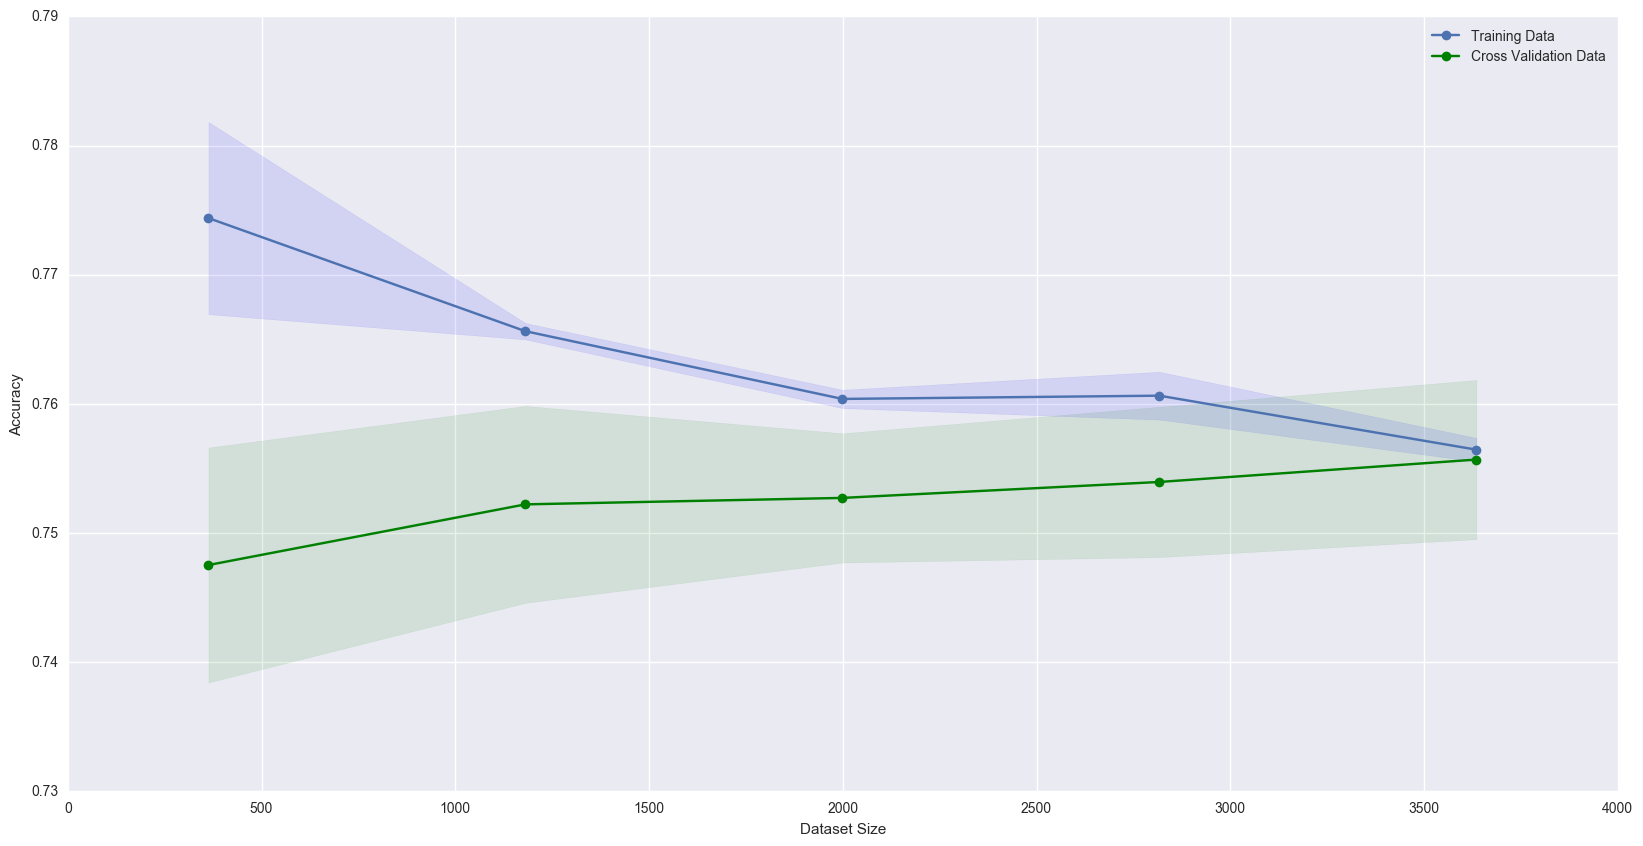

In [48]:
plt.fill_between(train_sizes,y_train_mean-y_train_std,y_train_mean+y_train_std,color='b',alpha=0.1)
plt.fill_between(train_sizes,y_test_mean-y_test_std,y_test_mean+y_test_std,color='g',alpha=0.1)
plt.plot(train_sizes,y_train,'o-',label='Training Data')
plt.plot(train_sizes,y_test,'o-',color='g',label='Cross Validation Data')
plt.xlabel('Dataset Size')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

In [49]:
polite_words = [
    "please","thanks","thank you","think", "thought", "thinking", "almost",
    "apparent", "apparently", "appear", "appeared", "appears", "approximately", "around",
    "assume", "assumed", "certain amount", "certain extent", "certain level", "claim",
    "claimed", "doubt", "doubtful", "essentially", "estimate",
    "estimated", "feel", "felt", "frequently", "from our perspective", "generally", "guess",
    "in general", "in most cases", "in most instances", "in our view", "indicate", "indicated",
    "largely", "likely", "mainly", "may", "maybe", "might", "mostly", "often", "on the whole",
    "ought", "perhaps", "plausible", "plausibly", "possible", "possibly", "postulate",
    "postulated", "presumable", "probable", "probably", "relatively", "roughly", "seems",
    "should", "sometimes", "somewhat", "suggest", "suggested", "suppose", "suspect", "tend to",
    "tends to", "typical", "typically", "uncertain", "uncertainly", "unclear", "unclearly",
    "unlikely", "usually", "broadly", "tended to", "presumably", "suggests",
    "from this perspective", "from my perspective", "in my view", "in this view", "in our opinion",
    "in my opinion", "to my knowledge", "fairly", "quite", "rather", "argue", "argues", "argued",
    "claims", "feels", "indicates", "supposed", "supposes", "suspects", "postulates"
]

In [58]:
from nltk import ngrams

In [74]:
politeness_new = []
count = 0
for request in df_train.request_text_edit_aware:
    count += 1
    request_ngrams = []
    for grams in ngrams(request.split(),3):
        request_ngrams.append(' '.join(grams))
    for grams in ngrams(request.split(),2):
        request_ngrams.append(' '.join(grams))
    request_words = set(request.split())
    request_ngrams = set(request_ngrams)
    num = len(request_words.intersection(set(polite_words))) +\
    len(request_ngrams.intersection(set(polite_words)))
    try:
        politeness_new.append(float(num)/len(request_words))
    except:
        politeness_new.append(0.0)
print 'Total Number of request parsed: ',count
df_train['politeness_new'] = politeness_new

Total Number of request parsed:  4040
